In [34]:
# necessary imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [35]:
# Load the data
df = pd.read_csv('../data/processed/premiums_rest.csv')
df.head()

,age,number_of_dependants,income_lakhs,insurance_plan,annual_premium_amount,risk_score,gender_male,region_northwest,region_southeast,region_southwest,marital_status_unmarried,bmi_category_obesity,bmi_category_overweight,bmi_category_underweight,smoking_status_occasional,smoking_status_regular,employment_status_salaried,employment_status_self_employed
0,26,0,6,1,9053,6,True,True,False,False,True,False,False,False,False,False,True,False
1,29,2,6,1,16339,6,False,False,True,False,False,True,False,False,False,True,True,False
2,49,2,20,2,18164,6,False,False,False,False,False,False,False,False,False,False,False,True
3,30,3,77,3,20303,0,False,False,True,False,False,False,False,False,False,False,True,False
4,56,3,14,1,15610,6,True,False,False,False,False,True,False,False,True,False,False,True


In [36]:
# machine learning imports
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# models
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from xgboost import XGBRegressor


### Why MinMaxScaler and Why Scale Before Splitting?

In [37]:
# Scale the data before split
df["genetical_risk"] = 0
scaler = MinMaxScaler()
cols_to_scale = ["age", "number_of_dependants","income_lakhs", "insurance_plan", "risk_score", "genetical_risk"]

X_train, X_test, y_train, y_test = train_test_split(df.drop("annual_premium_amount", axis=1), df["annual_premium_amount"], test_size=0.3, random_state=42)

scaler.fit(X_train[cols_to_scale])

MinMaxScaler()

In [38]:
X_train = X_train.copy()
X_train[cols_to_scale] = scaler.transform(X_train[cols_to_scale])
X_test = X_test.copy()
X_test[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (20875, 18)
X_test shape:  (8947, 18)
y_train shape:  (20875,)
y_test shape:  (8947,)


In [39]:
# Linear Regression Training
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

# Predictions
y_pred_lr = model_lr.predict(X_test)

# Evaluation
r2_lr_train = model_lr.score(X_train, y_train)
r2_lr_test = model_lr.score(X_test, y_test)

print("Linear Regression Model R2 Scores:")
print("Train: ", r2_lr_train)
print(" Test: ", r2_lr_test)

Linear Regression Model R2 Scores:
Train:  0.9530815646744318
 Test:  0.9546117251336064


In [40]:
features_importances = model_lr.coef_

coef_df = pd.DataFrame(features_importances, index=X_test.columns, columns=["Coefficients"])
coef_df = coef_df.sort_values(by="Coefficients", ascending=True)
coef_df

,Coefficients
number_of_dependants,-1247.793379
income_lakhs,-748.504739
marital_status_unmarried,-702.171931
region_northwest,-76.165657
employment_status_salaried,-73.460134
region_southwest,-53.337792
region_southeast,-25.083317
genetical_risk,0.000000
gender_male,42.765804
employment_status_self_employed,248.754208


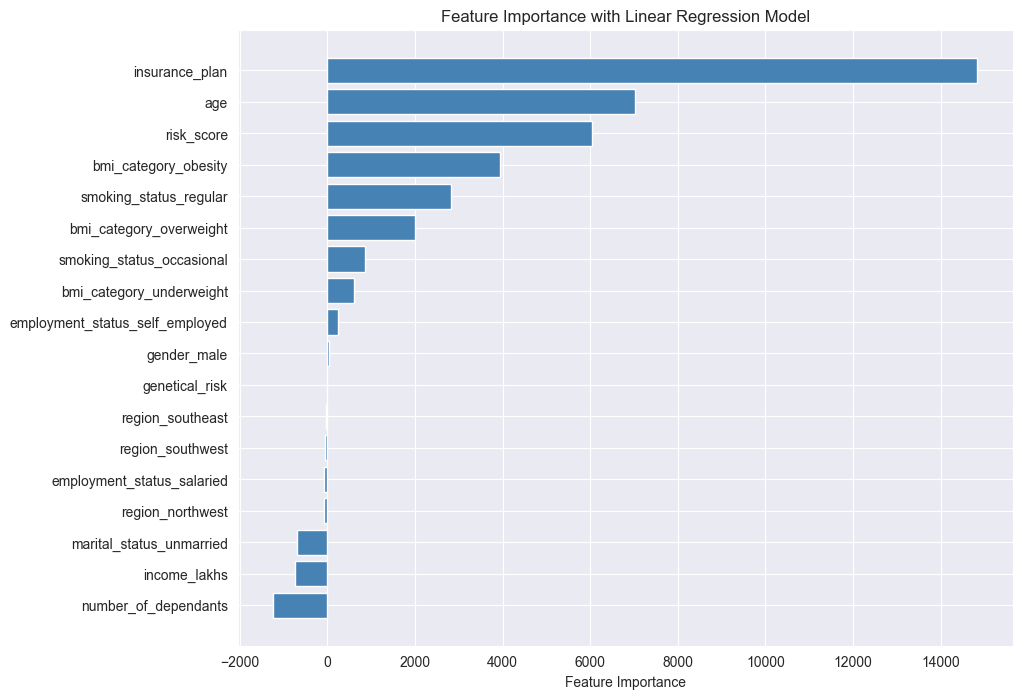

In [41]:
# Feature Importance with horizontal bar plot
plt.figure(figsize=(10, 8))
plt.barh(coef_df.index, coef_df["Coefficients"], color="steelblue")
plt.xlabel("Feature Importance")
plt.title("Feature Importance with Linear Regression Model")
plt.show()

### Insight: Linear Regression Interpretation
- The most important feature is `insurance_plan` with a positive coefficient.
- The second most important feature is `risk_score` with a positive coefficient.
- The least important feature is `region` with values close to zero.

In [42]:
from sklearn.linear_model import RidgeCV
alphas = np.logspace(-2, 2, 50)

model_rcv = RidgeCV(alphas=alphas, cv=5)
model_rcv.fit(X_train, y_train)

# Scores between train and test
print("RidgeCV best alpha: ", model_rcv.alpha_)

# Find the best alpha with
r2_rcv_train = model_rcv.score(X_train, y_train)
r2_rcv_test = model_rcv.score(X_test, y_test)

print("RidgeCV Model R2 Scores:")
print("Train: ", r2_rcv_train)
print(" Test: ", r2_rcv_test)



RidgeCV best alpha:  0.16768329368110074
RidgeCV Model R2 Scores:
Train:  0.9530815599386192
 Test:  0.954611847700529


In [43]:
features_importances_rcv = model_rcv.coef_
coef_df_rcv = pd.DataFrame(features_importances_rcv, index=X_test.columns, columns=["Coefficients"])
coef_df_rcv = coef_df_rcv.sort_values(by="Coefficients", ascending=True)

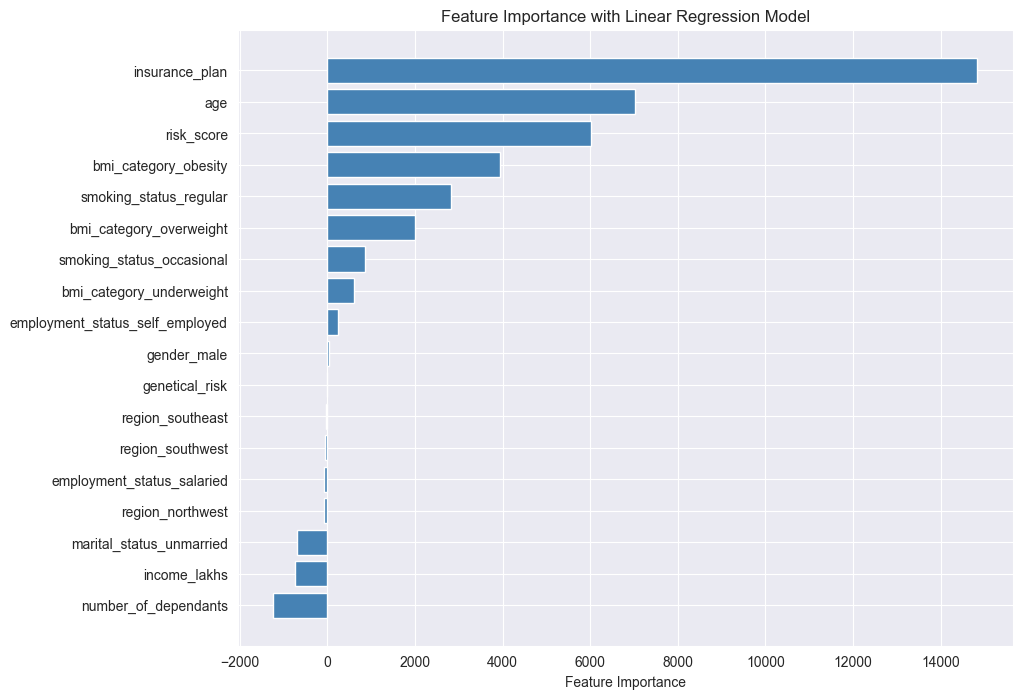

In [44]:
# Feature Importance with horizontal bar plot
plt.figure(figsize=(10, 8))
plt.barh(coef_df.index, coef_df_rcv["Coefficients"], color="steelblue")
plt.xlabel("Feature Importance")
plt.title("Feature Importance with Linear Regression Model")
plt.show()

In [45]:
from sklearn.linear_model import LassoCV

# decrease eps for finer search
# increase n_alphas for more alphas and more thorough search
model_lcv = LassoCV(eps=0.0001, n_alphas=200, cv=5)
model_lcv.fit(X_train, y_train)

# Get the best alpha
print("LassoCV best alpha: ", model_lcv.alpha_)

# Scores between train and test
r2_lcv_train = model_lcv.score(X_train, y_train)
r2_lcv_test = model_lcv.score(X_test, y_test)

print("LassoCV Model R2 Scores:")
print("Train: ", r2_lcv_train)
print(" Test: ", r2_lcv_test)

LassoCV best alpha:  0.3197848771420028
LassoCV Model R2 Scores:
Train:  0.9530809684801506
 Test:  0.9546161741096596


In [46]:
features_importances_lcv = model_lcv.coef_
coef_df_lcv = pd.DataFrame(features_importances_lcv, index=X_test.columns, columns=["Coefficients"])
coef_df_lcv = coef_df_lcv.sort_values(by="Coefficients", ascending=True)

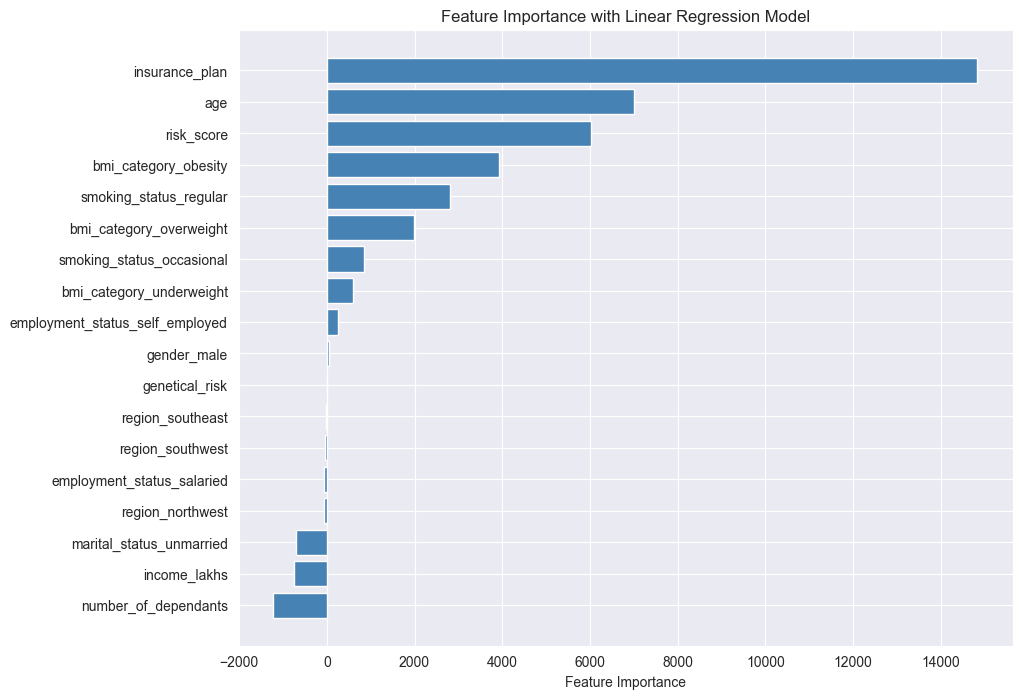

In [47]:
# Feature Importance with horizontal bar plot
plt.figure(figsize=(10, 8))
plt.barh(coef_df.index, coef_df_lcv["Coefficients"], color="steelblue")
plt.xlabel("Feature Importance")
plt.title("Feature Importance with Linear Regression Model")
plt.show()

### Insight: RidgeCV, Lasso, and Linear Regression Comparison
- The feature importances are similar in RidgeCV and Linear Regression models which makes sense since we moved multicollinearity between features with VIF analysis in Feature Engineering and Selection.
-

In [48]:
# Lets try xgboost

model_xgb = XGBRegressor()
model_xgb.fit(X_train, y_train)
train_score = model_xgb.score(X_train, y_train)
test_score = model_xgb.score(X_test, y_test)
print("XGBoost Model R2 Scores:")
print("Train: ", train_score)
print(" Test: ", test_score)

XGBoost Model R2 Scores:
Train:  0.9986407160758972
 Test:  0.9980074167251587


In [49]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error

In [50]:
y_pred = model_xgb.predict(X_test)
mse_xgb = mean_squared_error(y_test, y_pred)
rmse_xgb = np.sqrt(mse_xgb)
print("XGBoost RMSE: ", rmse_xgb)
print("XGBoost MSE: ", mse_xgb)

XGBoost RMSE:  309.6301977763151
XGBoost MSE:  95870.859375


In [51]:
# Create random search cv
from sklearn.model_selection import RandomizedSearchCV


In [52]:
model_xgb_2 = XGBRegressor()
param_grid = {
    'n_estimators': [20, 40, 50],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
}

random_search = RandomizedSearchCV(
    model_xgb_2,
    param_distributions=param_grid,
    n_iter=9,
    cv=3,
    verbose=0,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)
random_search.best_score_

np.float64(0.9970021843910217)

In [53]:
random_search.best_params_

{'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1}

In [54]:
best_model_xgb = random_search.best_estimator_

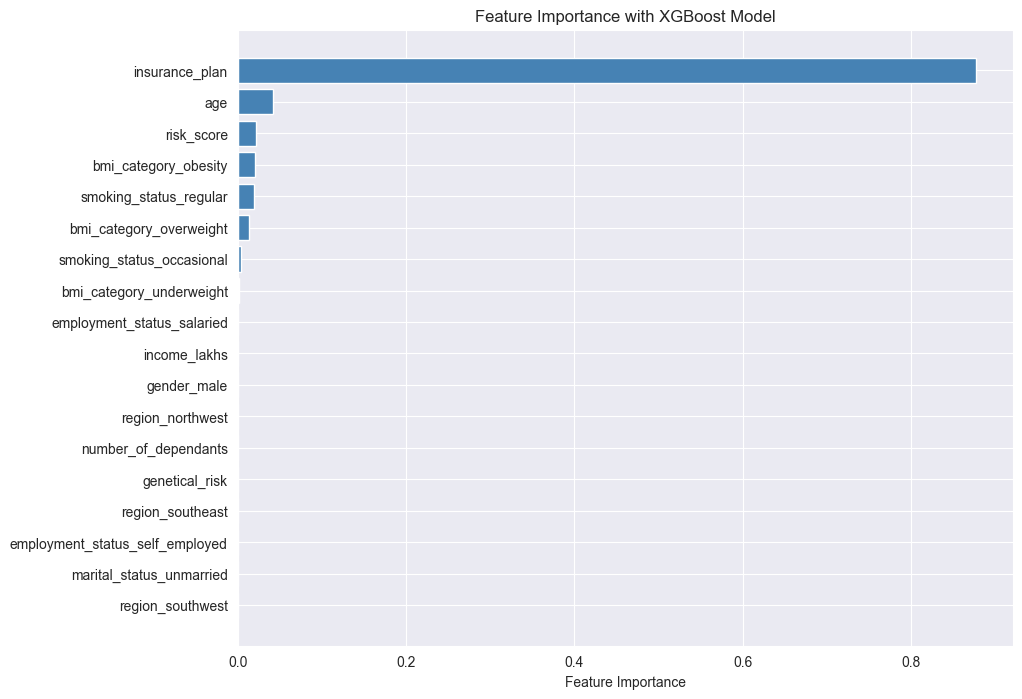

In [55]:
features_importances = best_model_xgb.feature_importances_
coef_df = pd.DataFrame(features_importances, index=X_test.columns, columns=["Coefficients"])
coef_df = coef_df.sort_values(by="Coefficients", ascending=True)

# Feature Importance with horizontal bar plot
plt.figure(figsize=(10, 8))
plt.barh(coef_df.index, coef_df["Coefficients"], color="steelblue")
plt.xlabel("Feature Importance")
plt.title("Feature Importance with XGBoost Model")
plt.show()

## 🔍 Feature Importance Analysis from XGBoost Model

The chart above displays the feature importances derived from the **XGBoost regression model** using the `feature_importances_` attribute, which is based on the **gain** (i.e., improvement in split quality) of each feature across all trees in the ensemble.

### 🧠 Key Observations:
- **`insurance_plan`** and **`age`** dominate the model, accounting for the overwhelming majority of importance. These features likely have the strongest influence on predicting the target variable.
- Other features like `risk_score`, `smoking_status_regular`, and `bmi_category_obesity` contribute marginally, but their impact is relatively small.
- Many features (e.g., `region`, `employment_status`, `marital_status`) have **very low or even zero** importance in this model — possibly because:
  - They don’t provide much gain after the top variables are used.
  - They may be highly collinear or redundant in decision paths.

### ⚠️ Interpretation Caution:
While this plot is useful, interpreting feature importance in XGBoost isn't as direct as in **linear models**:
- These values don’t represent a *directional* effect (e.g., positive or negative influence).
- Importance scores are **not normalized weights** or coefficients — they reflect **how often and effectively** a feature was used in tree splits.
- A high importance does not imply **causation**, just utility in splitting.

# Error Analysis

In [56]:
y_pred = best_model_xgb.predict(X_test)
residuals = y_pred - y_test
residuals_pct = residuals/(y_test)*100

results_df = pd.DataFrame({
    'actual': y_test,
    "predicted": y_pred,
    "diff": residuals,
    "diff_pct": residuals_pct
})

results_df.head()

,actual,predicted,diff,diff_pct
5477,30838,31168.615234,330.615234,1.072103
579,26306,26138.769531,-167.230469,-0.635712
279,17983,17611.283203,-371.716797,-2.067046
15395,19345,18925.240234,-419.759766,-2.169862
24210,33317,33256.734375,-60.265625,-0.180886


<Axes: xlabel='diff_pct', ylabel='Count'>

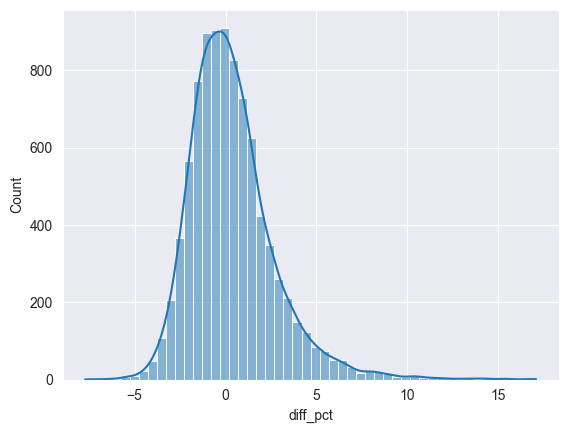

In [57]:
sns.histplot(results_df["diff_pct"], bins=50, kde=True)

### Distribution Problems
With model segmentation, we see that most of the predictions falls below the threshold and an extremely small number of predictions would be considered problematic.


In [58]:
extreme_error_threshold = 10
extreme_results_df = results_df[np.abs(results_df.diff_pct) > extreme_error_threshold]
extreme_results_df.shape

(45, 4)

In [59]:
extreme_errors_pct = extreme_results_df.shape[0] / results_df.shape[0] * 100
print(f"Extreme errors percentage: {extreme_errors_pct:.2f}%")

Extreme errors percentage: 0.50%


Export the Model

In [60]:
from joblib import dump

dump(best_model_xgb, "../artifacts/model_rest.joblib")
scaler_with_cols = {
    'scaler': scaler,
    'cols_to_scale': cols_to_scale
}
dump(scaler_with_cols, "../artifacts/scaler_rest.joblib")

['../artifacts/scaler_rest.joblib']